[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/02_cnn_development/05_pytorch_cnn_classifier.ipynb)

# 🛰️ 05: Baseline CNN Architecture & Optimization (PyTorch)
### Geospatial Land Classification Study (PyTorch Phase)
(*This is the 5th module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This research module establishes the **PyTorch-based supervised learning baseline** for the geospatial classification task. We evaluate the performance of a custom Convolutional Neural Network (CNN) designed to mirror the architectural complexity of the Keras baseline (Module 04). 

**Key Technical Focus:**
* **Imperative Model Design:** Constructing a streamlined feature extractor using the **torch.nn.Sequential** container for rapid baseline prototyping.
* **Stochastic Regularization:** Implementing `nn.Dropout` and `nn.BatchNorm2d` to ensure architectural parity with the Keras baseline.
* **Tensor Optimization:** Utilizing the **Adam** optimizer with **nn.CrossEntropyLoss()** for multi-class categorical optimization (modeled as a 2-node output for binary classification)
* **Cross-Framework Benchmarking:** Generating the reference artifacts required for the framework performance study in **Module 06**.

## Introduction

This module develops the PyTorch baseline corresponding to the Keras implementation in Module 04. By utilizing a modular Convolutional Neural Network (CNN) architecture, we establish a performance benchmark for the classification of agricultural imagery. This model serves as a critical comparison point for the Module 06 Comparative Analysis and the Module 09 Hybrid Integration.

## Table of Contents
<font size = 3> 

1. [Implementation Environment & Dependency Management](#Implementation-Environment-&-Dependency-Management)
2. [Deterministic Seeding & Experimental Integrity](#Deterministic-Seeding-&-Experimental-Integrity)
3. [Data Ingestion & Transformation Pipeline](#Data-Ingestion-&-Transformation-Pipeline)
4. [CNN Architecture Design & Layer Specifications](#CNN-Architecture-Design-&-Layer-Specifications)
5. [Training and validation](#Training-and-validation)
6. [Performance-visualization](#Performance-visualization)
7. [Final model evaluation](#Final-model-evaluation)

</font>



## Implementation Environment & Dependency Management


In [1]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 torch==2.7.0\
        torchvision==0.22 scikit-learn==1.7.0 requests tqdm==4.66.5 Pillow --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

✅ Environment: Local System. Directory: /home/ml/projects/GitHub/notebooks/02_cnn_development


In [2]:
# Set up a quiet environment for TensorFlow and Keras operations
import warnings, logging

# --- 1. System & Library Silence ---
# '3' to only display error messages from its C++ backend.
# This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# '0' disables verbose logging about optimizations and precision details.
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0' 
# "0" to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behavior on specific hardware configurations.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 

# --- 2. Python Warning Suppression ---
# Ignore standard warnings (e.g., deprecated functions in TFP or Matplotlib).
warnings.filterwarnings('ignore')

### Import libraries


In [3]:
%%time
# --- Common Imports ---
import time
import requests, tarfile, subprocess
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- PyTorch Libraries Imports---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split

from sklearn.metrics import accuracy_score
print("Succesfully imported libraries")

Succesfully imported libraries
CPU times: user 4.25 s, sys: 1.76 s, total: 6 s
Wall time: 4.83 s


### Hardware Acceleration & GPU Utilization
Check the availability of GPU

In [4]:
# GPU Detection and Specification
# 1. Check  the GPU
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    device = torch.device("cuda")
    print(f'✅ Found GPU at: {device}')
    
    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    try:
        output = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=gpu_name,driver_version,memory.total", "--format=csv"],
            encoding="utf-8"
        )
        print(output)
    except Exception as e:
        print("⚠️ Could not run nvidia-smi. This may happen inside WSL or restricted environments.")
        print(f"Error: {e}")

else:
    device = torch.device("cpu")
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, go to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')



✅ Found GPU at: cuda

Hardware Specifications:
name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB



## Deterministic Seeding & Experimental Integrity

The random seeds for `random` module, NumPy, and PyTorch are assigned a fixed value and cuDNN is configured for deterministic kernels. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.

Unlike TensorFlow that has a single `tf.random.set_seed(seed)`, in PyTorch it is necessary to set these seeds:
* **PyTorch CPU / GPU** – `torch.manual_seed` covers every op executed on the CPU, while `torch.cuda.manual_seed_all` applies the same seed to each GPU stream so that multi-GPU jobs stay in sync.
* **cuDNN flags** – By default cuDNN picks the fastest convolution algorithm, which can vary run-to-run. Setting `deterministic=True` forces repeatable kernels and turning `benchmark` *off* prevents the auto-tuner from replacing those kernels mid-training.

In [5]:
# Define a function to set seeds for reproducibility
SEED = 42
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set PyTorch seed (CPU + CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
    # 5. Force deterministic algorithms (Optional but recommended for full reproducibility)
    torch.backends.cudnn.deterministic = True # Ensures deterministic behavior for convolutional operations
    torch.backends.cudnn.benchmark = False # Disables the inbuilt cudnn auto-tuner that finds the best algorithm to use ofr the hardware.
                                           # This can lead to non-deterministic results.

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(SEED)

Reproducibility set with seed: 42


#### A `worker_init_fn` function has been defined so that each `DataLoader` worker starts from a reproducible seed as well.

PyTorch offsets each worker’s seed by default, injecting new randomness. For reproducible results, workers are set to start from **fixed** seeds so every data-augmentation decision (flip, crop, colour-jitter) is repeatable across runs. The `worker_init_fn` function re-seeds Python, NumPy, and PyTorch CPU random-number generators inside **each** worker using a simple deterministic formula (`SEED + worker_id`).  The result will be identical batches, identical gradients, and identical model checkpoints, run after run.

In [6]:
def worker_init_fn(worker_id: int) -> None:
    """Re-seed each DataLoader worker so their RNGs don't collide."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed) 
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

## Data Ingestion & Transformation Pipeline

The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.

In [7]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
# For simplicity extract to the base directory.
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.

    Args:
        - url (str): The URL to download the dataset from.
        - destination (str): The local file path where the downloaded archive will be saved.
        - extract_to (str): The directory where the contents of the archive will be extracted.
    
    Returns:
        None
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [8]:
# Define directories
dataset_path = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(dataset_path, 'class_0_non_agri')
dir_agri = os.path.join(dataset_path, 'class_1_agri')

print(f"Dataset path: {dataset_path}")
print(f"Non-agricoltural images directory: {dir_non_agri}")
print(f"Agricoltural images directory: {dir_agri}")

Dataset path: ./images_dataSAT
Non-agricoltural images directory: ./images_dataSAT/class_0_non_agri
Agricoltural images directory: ./images_dataSAT/class_1_agri


### Definition of model hyperparameters

This cell initializes several key **hyperparameters** that will govern the training process and the model's input. Here is the list of hyperparameters:

- **`img_size`**: The spatial resolution (height and width) to which all images will be resized. This ensures that the input to the neural network is of a consistent size.
- **`batch_size`**: The number of training examples utilized in one iteration (one forward and backward pass). A larger batch size can lead to faster training but requires more memory.
- **`lr` (Learning Rate)**: A crucial hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function.
- **`epochs`**: The number of times the learning algorithm will work through the entire training dataset.
- **`model_name`**: The name of the model file that will be created after training. This is useful for saving the checkpoint while training.


In [9]:
img_size = 64
batch_size = 128
lr = 0.001 # Learning rate for the optimizer. 
epochs = 20 # Set to the same number of epochs of the TensorFLow version for fair comparison.
model_name = "pytorch_state_dict.pth"
num_classes = 2 # Number of classes in the dataset.


#### Definition of transformations
The sequence of operations applied to the training images, include **data augmentation** techniques like `RandomRotation`, `RandomHorizontalFlip`, and `RandomAffine`. Augmentation artificially expands the training dataset by creating modified versions of images, which helps the model generalize better and reduces overfitting. The pipeline also resizes the image, converts it to a PyTorch tensor, and normalizes its pixel values.

Types of **`transforms`** used for data augmentation: 
- `transforms.Resize` : To resize all input images to a fixed size, useful for input vector with fixed dimensions for model training
- `transforms.RandomRotation`: For geometrical rotation
- `transforms.RandomHorizontalFlip`: For Geometrical horizontal flipping
- `transforms.RandomAffine`: For adjusting to a different point-of-view

The image array is then converted to a Tensor using `transforms.ToTensor()`.

And finally, the images are normalize between [-1,1] using `transforms.Normalize`.


In [10]:
# Define training transformation pipeline

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.485, 0.456, 0.406]), std=([0.229, 0.224, 0.225]))
])


The validataion dataset is just for validating the preformace of the model and hence, doesn't need to augment the input images. 
The transformations applied to the images are in this case: 
- `transforms.Resize` : To resize all input images to a fixed size
- `transforms.ToTensor()`
-  `transforms.Normalize`


In [11]:
# Define the validation transformation pipeline

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.485, 0.456, 0.406]), std=([0.229, 0.224, 0.225]))
])

### Loading dataset

The **`datasets.ImageFolder`**  automatically loads an image dataset from a directory (`dataset_path`) where subdirectories are named after their corresponding classes (e.g., `data/agri`, `data/non_agri`).

In [12]:
full_dataset = datasets.ImageFolder(dataset_path)

### Dataset split: Train, Validation, and Test

The next step in the data loading pipeline is to split the image dataset for training and validation and test. 

The `random_split` method from `torch.utils.data` allows to randomly split the input data based on a pre-defined split ratio. 

This separation is crucial for assessing how well the model generalizes to unseen data.

The ratio used is 80% (0.8) of the dataset for training and 10% (0.10) for validation, and 10% (0.10) for the test set.


In [13]:
# Define the split sizes
total_size = len(full_dataset)
test_size = int(0.1 * total_size)
val_size = int(0.1 * total_size)
train_size = total_size - test_size - val_size

# Perform the split using indices
train_indices, val_indices, test_indices = random_split(
    range(total_size), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Define a Wrapper Class to apply specific transforms
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Create independent subsets
train_dataset = TransformedSubset(Subset(full_dataset, train_indices), transform=train_transform)
val_dataset = TransformedSubset(Subset(full_dataset, val_indices), transform=val_transform)
test_dataset = TransformedSubset(Subset(full_dataset, test_indices), transform=val_transform)

print(f"✅ Split Verified: Train({len(train_dataset)}), Val({len(val_dataset)}), Test({len(test_dataset)})")

✅ Split Verified: Train(4800), Val(600), Test(600)


### Implementation of Training DataLoader

The `DataLoader` from `torch.utils.data` class is used to create a dataset generator for lazy loading of the training dataset.

- **`DataLoader`**: These objects wrap the datasets and provide an efficient, iterable way to feed data to the model in batches. `shuffle=True` for the `train_loader` ensures that the model sees the data in a different order each epoch, which helps prevent it from learning the order of the training examples. `worker_init_fn` ensures that **fixed seed** is passed to the `dataloader` for reproducibility.

Arguments: 
- `train_dataset`: The training image dataset
- `batch_size`: The number of images to be loaded in each batch
- `shuffle`: Set to *True* to load images from the dataset in random order
- `num_workers`: Number of parallel processes used to load the images. This is for optimum utilization the CPU cores to reduce the image I/O bottleneck
- `worker_init_fn`: For function to decide on data augmentation. The default is with *random seed* for better generalization or *fixed seed* for reproducible results.


In [14]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

### Implementation of Validation DataLoader

In [15]:
# Define validation dataloader

val_loader = DataLoader(val_dataset, 
                          batch_size=batch_size,
                          shuffle=False, # Shuffle is not necessary for the validation dataset
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

### Implementation of Test DataLoader

In [16]:
# Define validation dataloader

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=False, # Shuffle is not necessary for the validation dataset
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

In [17]:
print("Created Dataloaders. Now creating the model...")

Created Dataloaders. Now creating the model...


## CNN-Architecture-Design-&-Layer-Specifications

The architecture of the model was designed by adopting the following components for PyTorch:
- **`model = nn.Sequential(...)`**: A sequential container is used to build the model as a linear stack of layers. This is a convenient way to define a straightforward CNN.
  - **Convolutional Blocks**: The model consists of several blocks, each containing
      - a `Conv2d` layer for feature extraction,
      - a `ReLU` activation function,
      - a `MaxPool2d` layer to downsample and reduce dimensionality,
      - a`BatchNorm2d` to stabilize and accelerate training.    
  - **Classifier**: After the convolutional blocks,
      - `AdaptiveAvgPool2d` reduces each feature map to a single value, making the model more robust to input size variations.
      - `Flatten` converts the 2D feature maps into a 1D vector.
      - `Linear` (fully connected) layers then perform the final classification,
      - `Dropout` is used as a regularization technique to prevent overfitting.
  - **`.to(device)`**: This moves the model's parameters and buffers to the selected device (GPU, if available otherwise CPU).


In [18]:
# --- MODEL ---
model = nn.Sequential(
                        # Conv Block 1
                        nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
                        nn.MaxPool2d(2), nn.BatchNorm2d(32),
                        
                        # Conv Block 2-6
                        nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
                        nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
                        nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
                        nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
                        nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
                        
                        # Classifier
                        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                        nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
                        nn.Linear(2048, num_classes)
                    ).to(device)

### Definition of the training setup

After building the model, are defined the loss function and the optimizer for backpropagation and learning.

- The loss function is defined using **`criterion = nn.CrossEntropyLoss()`**
    - `CrossEntropyLoss` is specifically designed for multi classs classification problems.

- The optimizer is defined using **`optimizer = optim.Adam(...)`**:
    - The Adam optimizer is chosen to update the model's weights. It's an adaptive learning rate method that is computationally efficient and works well in practice.
 
- **history** is tracked using `best_loss`, `loss_history` and `acc_history` dictionaries
    - `best_loss`: stores the best validation loss achieved so far.
    - `loss_history` and `acc_history` dictionaries to log the loss and accuracy history for plotting later.


In [19]:
# --- TRAINING SETUP ---
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = float('inf')
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

print("Created Model. Now training the model...")

Created Model. Now training the model...


## Training and validation

The model iterates through the dataset for the specified number of epochs, with each epoch consisting of a training phase and a validation phase.

- **Outer Loop (`for epoch in range(epochs)`)**: Controls the number of full passes over the dataset.

- **The model is trained for 20 epochs** for best results and for consistency with the model trained in Keras.

- **Training Phase**:
  - `model.train()`: Sets the model to training mode. This activates layers like Dropout and ensures BatchNorm layers learn from the current batch statistics.
  - **Inner Loop (`for images, labels in train_loader`)**: Iterates over batches of training data.
  - `optimizer.zero_grad()`: Clears the gradients from the previous iteration before computing new ones.
  - `outputs = model(images)`: **Forward Pass**. The input data is passed through the network to get predictions (logits).
  - `loss.backward()`: **Backward Pass**. Gradients of the loss with respect to the model's parameters are calculated.
  - `optimizer.step()`: The optimizer updates the model's parameters using the computed gradients.
 
- **Validation Phase**:
  - `model.eval()`: Sets the model to evaluation mode. This deactivates Dropout and makes BatchNorm layers use their learned running statistics.
  - `with torch.no_grad()`: Disables gradient calculation, which speeds up computation and reduces memory usage since we aare only evaluating, not training.
 
- **Model Checkpointing**: After each epoch, the current validation loss is compared to the `best_loss` seen so far. If the current loss is lower, the model's state (`model.state_dict()`) is saved to a file. This allows us tokeep the model version that performed best on the validation set.


In [20]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

# --- TRAINING LOOP ---
for epoch in range(epochs):
    # Training Phase
    start_time = time.time() # To get the training time for each epoch.
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0  # Reset the training metrics.
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        images, labels = images.to(device), labels.to(device)  # Labels as integer class indices.
        optimizer.zero_grad()
        outputs = model(images)  # Forward pass, outputs are raw logits.
        loss = criterion(outputs, labels)  # Criterion is nn.CrossEntropyLoss.
        loss.backward() # Backward pass
        optimizer.step() # Update gradients
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
  
    # Synchronize CUDA before stopping timer (if using GPU)
    if device == 'cuda':
        torch.cuda.synchronize()

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0 #  for the validation metrics
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
  
    # Save the best model
    avg_val_loss = val_loss/len(val_loader)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    # Store metrics
    loss_history['train'].append(train_loss/len(train_loader))
    loss_history['val'].append(val_loss/len(val_loader))
    acc_history['train'].append(train_correct/train_total)
    acc_history['val'].append(val_correct/val_total)
    
    #print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f}")
    print(f"Train Acc: {acc_history['train'][-1]:.4f} | Val Acc: {acc_history['val'][-1]:.4f}")
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training completed in {epoch_time:.2f} seconds\n") 

print("Trained Model. Now evaluating the model...")

Training on : ===cuda=== with batch size: 128 & lr: 0.001


Epoch 1/20: 100%|██████████| 38/38 [00:02<00:00, 14.59it/s]


Train Loss: 0.3474 | Val Loss: 0.0915
Train Acc: 0.9308 | Val Acc: 0.9783
Epoch 1 training completed in 2.93 seconds



Epoch 2/20: 100%|██████████| 38/38 [00:01<00:00, 21.35it/s]


Train Loss: 0.0271 | Val Loss: 0.0276
Train Acc: 0.9910 | Val Acc: 0.9900
Epoch 2 training completed in 2.14 seconds



Epoch 3/20: 100%|██████████| 38/38 [00:01<00:00, 21.33it/s]


Train Loss: 0.0233 | Val Loss: 0.0103
Train Acc: 0.9923 | Val Acc: 0.9967
Epoch 3 training completed in 2.12 seconds



Epoch 4/20: 100%|██████████| 38/38 [00:01<00:00, 21.33it/s]


Train Loss: 0.0206 | Val Loss: 0.0068
Train Acc: 0.9933 | Val Acc: 0.9983
Epoch 4 training completed in 2.11 seconds



Epoch 5/20: 100%|██████████| 38/38 [00:01<00:00, 21.52it/s]


Train Loss: 0.0190 | Val Loss: 0.0350
Train Acc: 0.9940 | Val Acc: 0.9883
Epoch 5 training completed in 1.95 seconds



Epoch 6/20: 100%|██████████| 38/38 [00:01<00:00, 21.80it/s]


Train Loss: 0.0228 | Val Loss: 0.0295
Train Acc: 0.9927 | Val Acc: 0.9850
Epoch 6 training completed in 1.94 seconds



Epoch 7/20: 100%|██████████| 38/38 [00:01<00:00, 21.28it/s]


Train Loss: 0.0191 | Val Loss: 0.0074
Train Acc: 0.9927 | Val Acc: 0.9983
Epoch 7 training completed in 1.99 seconds



Epoch 8/20: 100%|██████████| 38/38 [00:01<00:00, 21.29it/s]


Train Loss: 0.0162 | Val Loss: 0.0117
Train Acc: 0.9952 | Val Acc: 0.9917
Epoch 8 training completed in 2.00 seconds



Epoch 9/20: 100%|██████████| 38/38 [00:01<00:00, 21.63it/s]


Train Loss: 0.0421 | Val Loss: 0.0168
Train Acc: 0.9875 | Val Acc: 0.9917
Epoch 9 training completed in 1.95 seconds



Epoch 10/20: 100%|██████████| 38/38 [00:01<00:00, 21.78it/s]


Train Loss: 0.0136 | Val Loss: 0.0114
Train Acc: 0.9954 | Val Acc: 0.9917
Epoch 10 training completed in 1.94 seconds



Epoch 11/20: 100%|██████████| 38/38 [00:01<00:00, 21.65it/s]


Train Loss: 0.0165 | Val Loss: 0.0439
Train Acc: 0.9946 | Val Acc: 0.9833
Epoch 11 training completed in 1.94 seconds



Epoch 12/20: 100%|██████████| 38/38 [00:01<00:00, 21.45it/s]


Train Loss: 0.0129 | Val Loss: 0.0093
Train Acc: 0.9956 | Val Acc: 0.9967
Epoch 12 training completed in 1.96 seconds



Epoch 13/20: 100%|██████████| 38/38 [00:01<00:00, 21.78it/s]


Train Loss: 0.0166 | Val Loss: 0.0056
Train Acc: 0.9946 | Val Acc: 0.9983
Epoch 13 training completed in 2.09 seconds



Epoch 14/20: 100%|██████████| 38/38 [00:01<00:00, 21.67it/s]


Train Loss: 0.0140 | Val Loss: 0.0021
Train Acc: 0.9956 | Val Acc: 1.0000
Epoch 14 training completed in 2.11 seconds



Epoch 15/20: 100%|██████████| 38/38 [00:01<00:00, 21.25it/s]


Train Loss: 0.0114 | Val Loss: 0.0148
Train Acc: 0.9962 | Val Acc: 0.9967
Epoch 15 training completed in 1.99 seconds



Epoch 16/20: 100%|██████████| 38/38 [00:01<00:00, 21.93it/s]


Train Loss: 0.0159 | Val Loss: 0.0427
Train Acc: 0.9948 | Val Acc: 0.9833
Epoch 16 training completed in 1.92 seconds



Epoch 17/20: 100%|██████████| 38/38 [00:01<00:00, 21.75it/s]


Train Loss: 0.0139 | Val Loss: 0.0273
Train Acc: 0.9967 | Val Acc: 0.9917
Epoch 17 training completed in 1.94 seconds



Epoch 18/20: 100%|██████████| 38/38 [00:01<00:00, 21.33it/s]


Train Loss: 0.0127 | Val Loss: 0.0081
Train Acc: 0.9944 | Val Acc: 0.9950
Epoch 18 training completed in 1.98 seconds



Epoch 19/20: 100%|██████████| 38/38 [00:01<00:00, 21.30it/s]


Train Loss: 0.0145 | Val Loss: 0.0554
Train Acc: 0.9950 | Val Acc: 0.9833
Epoch 19 training completed in 1.98 seconds



Epoch 20/20: 100%|██████████| 38/38 [00:01<00:00, 21.77it/s]


Train Loss: 0.0117 | Val Loss: 0.0050
Train Acc: 0.9962 | Val Acc: 0.9983
Epoch 20 training completed in 1.93 seconds

Trained Model. Now evaluating the model...


## Performance visualization

The following two plots are used to track the training history of a model:
- **Accuracy Plot**: Shows the training accuracy versus the validation accuracy. A large gap between the two curves can be an indicator of overfitting, where the model performs well on the data it has seen but poorly on new, unseen data.

- **Loss Plot**: Shows the training loss versus the validation loss. An ideal plot shows both losses decreasing and converging. If the validation loss starts to increase while the training loss continues to decrease, it's a strong sign of overfitting.

 
These plots provide an intuitive, visual summary of the entire training process and help diagnose potential issues or confirm that the model has trained successfully.


#### *Model Accuracy*


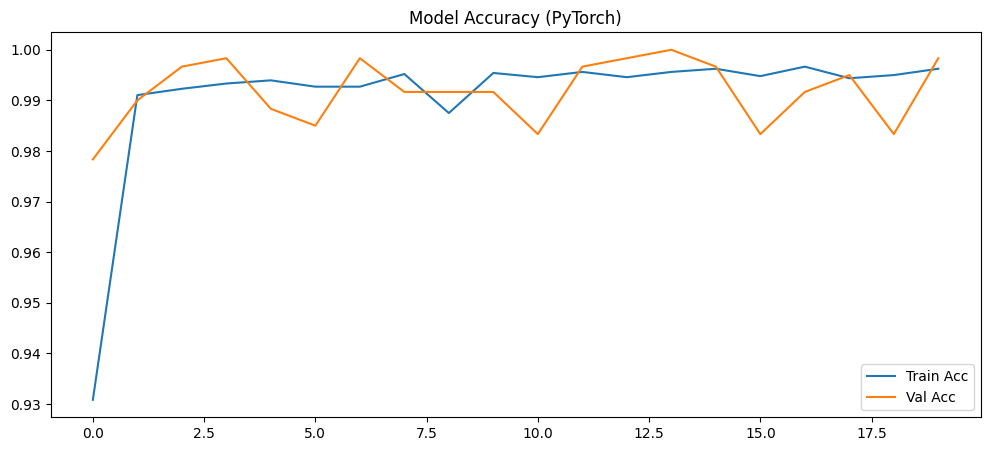

In [21]:
# # Plot training and validation accuracy during training
plt.figure(figsize=(12, 5))
plt.plot(acc_history['train'], label='Train Acc')
plt.plot(acc_history['val'], label='Val Acc')
plt.title('Model Accuracy (PyTorch)')
plt.legend()
plt.show()

#### *Model Loss*


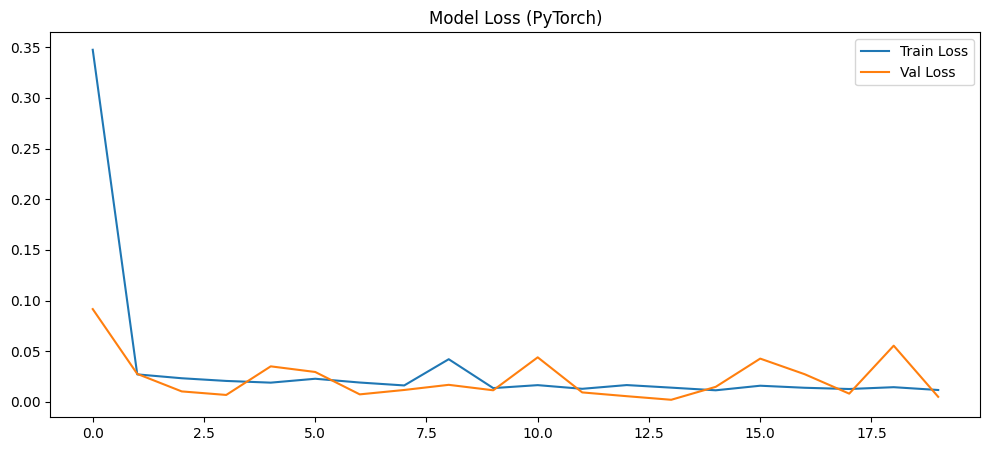

In [22]:
# Plot training and validation loss during training

plt.figure(figsize=(12, 5))
plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['val'], label='Val Loss')
plt.title('Model Loss (PyTorch)')
plt.legend()
plt.show()

## Final model evaluation

Finally the best-performing model saved during the training loop, is evaluated on the holdout dataset (`test_dataset`).


- **`model.eval()`**: Switches the model to evaluation mode.
- **`with torch.no_grad()`**: Disables gradient computation for efficiency.
- **Collecting Predictions**: The code iterates through the entire validation set to gather all predictions and their corresponding true labels.

- **`accuracy`**: The proportion of correct predictions out of the total predictions.


In [23]:
# Evaluate the model on the validation set and collect predictions and true labels for the classification report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # Move images to the same device as the model.
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1) # Get predicted class indices
        all_preds.extend(preds.cpu().numpy().flatten()) # Move predictions back to CPU and convert to Numpy before extending the List
        all_labels.extend(labels.numpy()) # Move Labels to CPU and convert to Numpy before extending the List

To calculate the **accuracy_score** was used `accuracy_score` from `sklearn.metrics` class.

In [24]:
# Calculate and print the accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"The accuracy of the model is: {accuracy:.4f}")

The accuracy of the model is: 0.9983


---
**Module 05 Conclusion:** This module successfully established the PyTorch-based CNN baseline. By implementing a modular architecture with integrated Batch Normalization and Dropout, we achieved parity with the Keras baseline's structural complexity. 

The resulting PyTorch model state-dict has been persisted, providing the necessary artifacts for the **Module 06 Framework Comparison** and serving as the second potential backbone for the **Module 09 Hybrid CNN-ViT Study**.